<a href="https://colab.research.google.com/github/algroznykh/notebooks/blob/master/texture_nca_pytorch_conv_in_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Texture Generation with Neural Cellular Automata -- Conv in Conv](https://distill.pub/selforg/2021/textures) (PyTorch version)

This notebook contains a minimalistic PyTorch implementation of the Texture Nerual CA model. For pretrained models and other experiments please refer to the [TF2 version](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/texture_nca_tf2.ipynb).

*Copyright 2021 Google LLC*

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-57f83a6c-2dc9-4258-94e6-6a5f90f00798)


In [ ]:
import torch
import torchvision.models as models

torch.set_default_tensor_type('torch.cuda.FloatTensor')

import torch.nn.functional as F

In [ ]:
# OT loss 

!pip install -q --progress-bar off pykeops[colab] geomloss

from geomloss import SamplesLoss
from torchvision.transforms.functional_tensor import gaussian_blur

def calc_styles_ot(img, ksize, leveln, show=False):
  levels = []
  for i in range(leveln):
    blured = gaussian_blur(img, [5, 5], [1, 1])
    unsharp = img + (img-blured)*2.0
    if show:
      imshow(unsharp[0].permute(1, 2, 0).cpu())
    win = F.unfold(unsharp, ksize).permute(0, 2, 1).contiguous()
    levels.append(win)
    if i<leveln-1:
      img = blured[:,:,::2,::2]
  return levels
 
opt_f = SamplesLoss()

def subsample(x, n=2048):
  if x.shape[1]>n:
    idx = torch.multinomial(torch.ones(x.shape[1]), n)
    x = x[:,idx]
  return x

def create_ot_loss(target_img, ksize=5, leveln=2, show=False):
  target_style = calc_styles_ot(target_img, ksize, leveln, show)
  def loss_f(imgs):
    xs = calc_styles_ot(imgs, ksize, leveln)
    loss = 0.0
    for x, y in zip(xs, target_style):
      x, y = subsample(x, 1024), subsample(y, 1024*2)
      y = y.repeat(x.shape[0], 1, 1)
      loss += opt_f(x, y).mean()
    return loss
  return loss_f

In [ ]:
#@title Neural CA
ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

class Weight(torch.nn.Module):
    def __init__(self):
        super(Weight, self).__init__()
        self.weight = torch.nn.Parameter(data=torch.Tensor(1), requires_grad=True)
        torch.nn.init.normal_(self.weight.data, mean=0, std=0.5)

    def forward(self, input):
        return input * self.weight

class Bias(torch.nn.Module):
  def __init__(self):
    super(Bias, self).__init__()
    self.bias = torch.nn.Parameter(data=torch.Tensor(1), requires_grad=True)
    torch.nn.init.normal_(self.bias.data, mean=0, std=0.5)

  def forward(self, input):
    return input + self.bias

def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
  y = torch.nn.functional.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

def perception(x):
  filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
  return perchannel_conv(x, filters)

class CA(torch.nn.Module):
  def __init__(self, chn=12, hidden_n=96):
    super().__init__()
    self.chn = chn
    g = chn * 4

    # 3 coef for 1d convolution on internal state
    self.c1 = Weight()
    self.c2 = Weight()
    self.c3 = Weight()
    self.bias = Bias()


    self.w2 = torch.nn.Conv2d(g, chn, 1, bias=False, groups=chn)
    self.w2.weight.data.zero_()

  def forward(self, x, update_rate=0.5, convn=1):
    y = perception(x)

    for _ in range(convn):

      # 1d conv on internal state
      h1 = self.c1(y.roll(-1,1))
      h2 = self.c2(y.roll(0,1))
      h3 = self.c3(y.roll(1,1))
      y = h1 + h2 + h3
      y = self.bias(y)
      y = torch.relu(y)

    y = self.w2(y)
    b, c, h, w = y.shape

    return x+y

  def seed(self, n, sz=128):
    return torch.randn(n, self.chn, sz, sz) / 10

def to_rgb(x):
  return x[...,:3,:,:]+0.5
  # return x[...,::4,:,:]+0.5


param_n = sum(p.numel() for p in CA().parameters())
print('CA param count:', param_n)

CA param count: 52


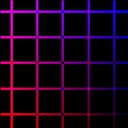

In [ ]:
#@title Target image {vertical-output: true}
style_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/04/Tempera%2C_charcoal_and_gouache_mountain_painting_by_Nicholas_Roerich.jpg/301px-Tempera%2C_charcoal_and_gouache_mountain_painting_by_Nicholas_Roerich.jpg'
style_img = imread(style_url, max_size=128)
style_img = imread('/content/grid.png', max_size=128)[...,:3]
with torch.no_grad():
  target_style = calc_styles(to_nchw(style_img))
  texture_loss_f = create_ot_loss(to_nchw(style_img), leveln=5)
imshow(style_img)

In [ ]:
#@title setup training
ca = CA() 
opt = torch.optim.Adam(ca.parameters(), 1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [2000], 0.3)
loss_log = []
with torch.no_grad():
  pool = ca.seed(256)

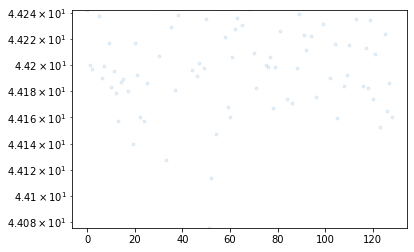

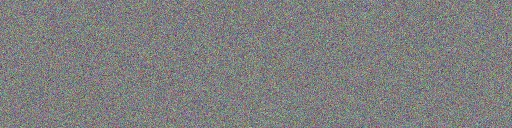

step_n: 181  loss: 44.25048828125  lr: 0.001

In [ ]:
#@title training loop {vertical-output: true}

def loss_f(x, lf):
  loss = lf(to_rgb(x))
  reg = (x-x.clamp(-1.0, 1.0)).square().sum()
  total_loss = loss + reg
  return total_loss


for i in range(4000):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x = pool[batch_idx]
    if i%8 == 0:
      x[:1] = ca.seed(1)
  # step_n = np.random.randint(32, 96)
  step_n = np.random.randint(16, 64)

  # The following line is equivalent to this code:
  #   for k in range(step_n):
  #     x = ca(x)
  # It uses gradient checkpointing to save memory, which enables larger
  # batches and longer CA step sequences. Surprisingly, this version
  # is also ~2x faster than a simple loop, even though it performs
  # the forward pass twice!
  # x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)
  for k in range(step_n):
      x = ca(x, convn=4)
  imgs = to_rgb(x)
  # styles = calc_styles(imgs)
  # overflow_loss = (x-x.clamp(-1.0, 1.0)).abs().sum()
  # loss = style_loss(styles, target_style)+overflow_loss
  loss = loss_f(x, texture_loss_f)
  with torch.no_grad():
    loss.backward()
    # for p in ca.parameters():
    #     p.grad /= (p.grad.norm()+1e-8)  # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool
    
    loss_log.append(loss.item())
    if i%64==0:
      clear_output(True)
      pl.plot(loss_log, '.', alpha=0.1)
      pl.yscale('log')
      pl.ylim(np.min(loss_log), loss_log[0])
      pl.show()
      imgs = to_rgb(x).permute([0, 2, 3, 1]).cpu()
      imshow(np.hstack(imgs))
    if i%10 == 0:
      print('\rstep_n:', len(loss_log),
        ' loss:', loss.item(), 
        ' lr:', lr_sched.get_lr()[0], end='')


In [ ]:
#@title NCA video {vertical-output: true}
attn_log = []
with VideoWriter() as vid, torch.no_grad():
  x = ca.seed(4, 256)
  for k in tnrange(300, leave=False):
    step_n = min(2**(k//30), 16)
    for i in range(step_n):
      x[:] = ca(x)
      # attn_log.append(ca.attn)
    img = to_rgb(x[0]).permute(1, 2, 0).cpu()
    vid.add(zoom(img, 2))

In [ ]:
#@title hidden states {vertical-output: true}
DAMAGE = False

with VideoWriter() as vid, torch.no_grad():
  x = ca.seed(1, sz=128)

#   x = torch.cat([makez2(1, sz=128), torch.zeros((1, 12-3, 128, 128))], 1)

  # initial frame
  img = np.vstack([np.hstack([to_rgb(x[:,row:row+3,...][0]).permute(1, 2, 0).cpu() for row in range(col, col+6)[::3]]) for col in range(ca.chn)[::6]])
  vid.add(zoom(img, 2))

  s = 0

  for k in tnrange(300, leave=False):
    step_n = min(2**(k//30), 16) // 2 + 1
    step_n = 4
    for i in range(step_n):
      x[:] = ca(x, convn=3)
      # x[:,3:6,...] = ca.seed(1, sz=128)[:,:3,...]

    if DAMAGE and (k+1) % 16 == 0:

      if s%4==0: 
        x[:,3:6,...] = ca.seed(1, sz=128)[:,:3,...]
      elif s%4==1:
        x[:,-6:-3,...] = ca.seed(1, sz=128)[:,:3,...]
      elif s%4 == 2:
        x[:,-3:,...] = ca.seed(1, sz=128)[:,:3,...]
      elif s%4 == 3:
        x[:,:3,...] = ca.seed(1, sz=128)[:,:3,...]

      # if s%2==0:
      #   x[:,-6:-3,...] = ca.seed(1, sz=128)[:,:3,...]
      # elif s%2 == 1:
      #   x[:,-3:,...] = ca.seed(1, sz=128)[:,:3,...]


      s += 1


    # img = to_rgb(x[0]).permute(1, 2, 0).cpu()
    img = np.vstack([np.hstack([to_rgb(x[:,row:row+3,...][0]).permute(1, 2, 0).cpu() for row in range(col, col+6)[::3]]) for col in range(ca.chn)[::6]])

    vid.add(zoom(img, 2))

In [ ]:
#@title hidden state PCA visualisation { vertical-output: true }
from sklearn.decomposition import PCA

SIZE=384
N_COMP = 6

# state = np.zeros([1, SIZE, SIZE, cfg.texture_ca.channel_n], np.float32)
state = ca.seed(1, SIZE)
state_hist = []
# collect state history to compute principal components
for i in tqdm_notebook(range(200)):
  with torch.no_grad():
    state = ca(state)
  if i > 60:
    state_hist.append(np.array(torch.reshape(state[0], (-1, 12)).cpu()))
hidden_states = np.concatenate(state_hist, axis=0)
pca = PCA(n_components=N_COMP)
pca.fit(hidden_states[:, 3:])
# quick and dirty way to normalize to [0,1] for visualisation: 
# assume the values going forward will be of 
# same scale, standardize so 3-std is in [0,1] 
sample = pca.transform(hidden_states[:, 3:])
std = np.std(sample, axis=0)
mean = np.mean(sample, axis=0)
state = ca.seed(1, SIZE)

In [ ]:
with torch.no_grad():
  state = ca.seed(1, sz=SIZE)

n1, n2 = 0,3

with VideoWriter("out.mp4", 60.0) as vid:
  for i in tqdm_notebook(range(60*8)):
    with torch.no_grad():
      state = ca(state)
    if i > 60:
      frame_pca = pca.transform(torch.reshape(state[0][3:,...].permute(1,2,0), (-1, 9)).cpu()).reshape((SIZE, SIZE, N_COMP))[...,n1:n2]
      frame_pca = (frame_pca - mean[n1:n2])/(2*std[n1:n2]) + 0.5 
      frame_pca = frame_pca[SIZE//4:3*SIZE//4, SIZE//4:3*SIZE//4,:]

      frame_vis = to_rgb(state[0][:3, ...]).cpu().permute(1,2,0)
      frame_vis = frame_vis[SIZE//4:3*SIZE//4, SIZE//4:3*SIZE//4,:]

      frame = np.hstack([frame_vis, frame_pca])
      vid.add(frame)
vid.show(width=1024)